# Лабораторная работа №6. Машины опорных векторов и ядра скалярного произведения
## ПМ-21М
### Егор Решетников


В данной лабораторной работе рассматривается использование машин опорных векторов для решения задач классификации и регрессии.

In [1]:
import numpy as np
import sklearn as sk
import sklearn.datasets
import sklearn.model_selection
import sklearn.svm 
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

## Задание №1

Подготовьте обучающую и тестовую выборки.
Значение `random_state` соответствует номеру варианта.
Размер тестовой выборки должен составлять 20% от исходной выборки.

(800, 2) (800,)


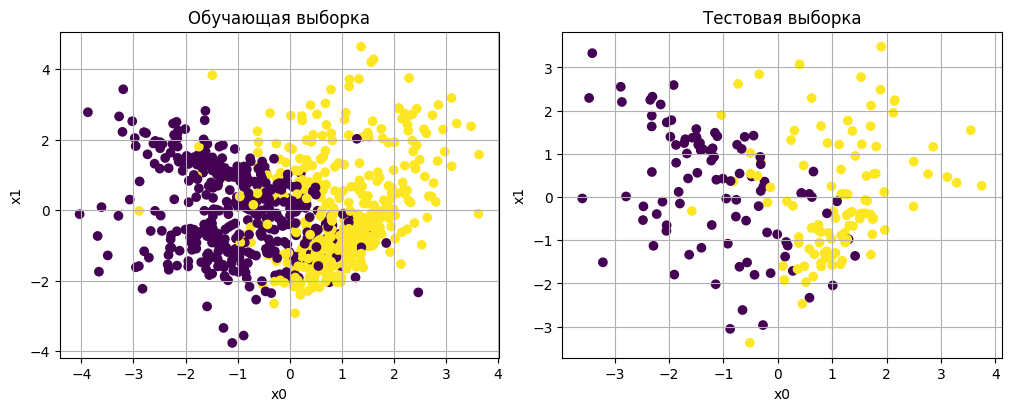

In [2]:
x, y = sk.datasets.make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=2, random_state=1)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state=42, test_size = 0.2)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*5, 4))
ax0.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
ax0.set(xlabel='x0', ylabel='x1', title='Обучающая выборка')

ax1.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax1.set(xlabel='x0', ylabel='x1', title='Тестовая выборка')

print(x_train.shape, y_train.shape)

## Задание №2

Рассмотрим задачу классификации с использованием машин опорных векторов.
Визуализируйте разделение пространства признаков для следующих ядер:

* линейное,
* полиномиальные (порядков 2-5),
* радиальное RBF.

Для каждого из ядер найдите точность (accuracy) для обучающей и тестовой выборок, а также число используемых опорных векторов (сложность модели).
На основе полученных значений точности (accuracy) выберите наилучшую модель.
Для полиномиальных ядер в отчет включите только ту модель, которая дает наилучший результат.
Число опорных векторов - это сумма опорных векторов всех классов в переменной `n_support_`.

linear train score: 0.85375 test score: 0.865 n_support: 302
rbf train score: 0.8775 test score: 0.865 n_support: 272
poly2 train score: 0.555 test score: 0.52 n_support: 731
poly3 train score: 0.83625 test score: 0.855 n_support: 392
poly4 train score: 0.55875 test score: 0.63 n_support: 725
poly5 train score: 0.74625 test score: 0.805 n_support: 505


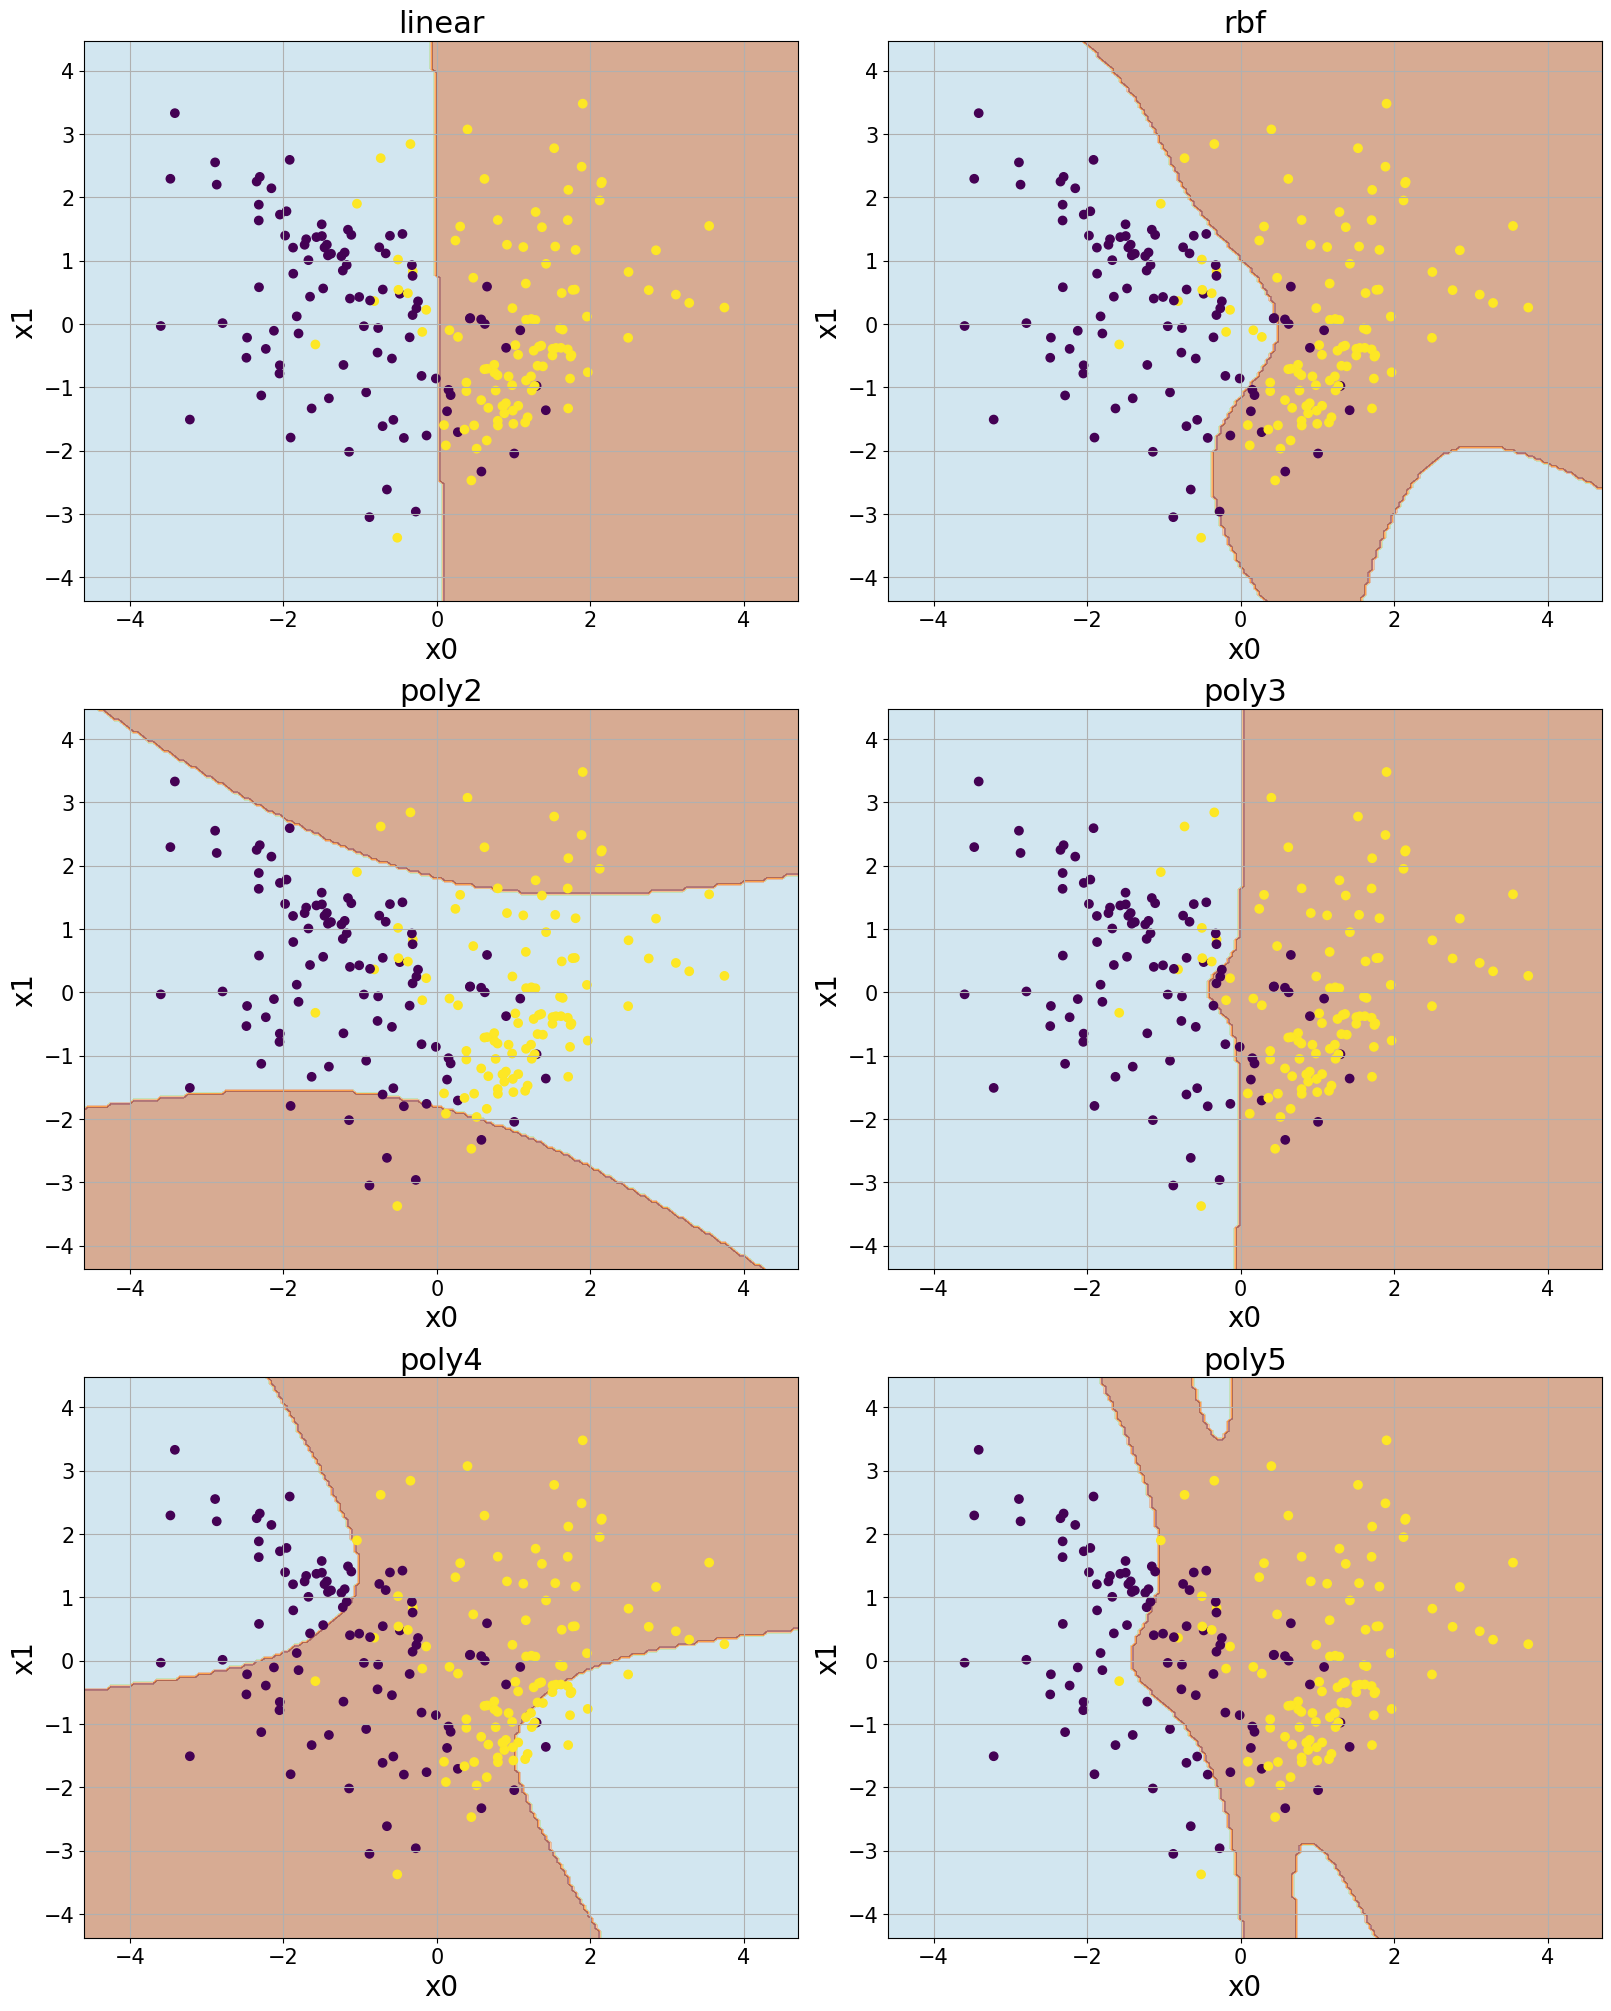

In [3]:
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

models = {'linear': sk.svm.SVC(kernel='linear'), 'rbf': sk.svm.SVC(kernel='rbf')}
for p in range(2, 6):
    models[f'poly{p}'] = sk.svm.SVC(kernel='poly', degree = p)

_, axes = plt.subplots(3, len(models)//3, figsize=(16, 20))
i = 0
for (name, model) in models.items():
    ax = axes[i // axes.shape[1],i % axes.shape[1]]
    model.fit(x_train,y_train)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])
    ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
    ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
    ax.set(title=name)
    ax.title.set_size(22)
    ax.set_xlabel('x0', fontsize=20)
    ax.set_ylabel('x1', fontsize=20)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)
    i += 1
    
    print(name, 'train score:', model.score(x_train, y_train), 'test score:', model.score(x_test, y_test), 'n_support:', model.n_support_.sum())


**Вопросы:**

1. Какая модель оказалась лучшей по точности классификации?
1. Какая модель использует наименьшее число опорных векторов?
1. Что можно сказать о влиянии числа опорных векторов на качество модели?

**Ответы:**

1. RBF оказался лучше
2. RBF
3. В нашем случае рост числа опорных векторов ухудшает результаты


## Задание №3

Пусть задача минимизации функции стоимости имеет вид
$$
\frac{1}{2} \lVert\mathbf{w}\rVert^2 + C \sum_{i=0}^{N-1} \xi_i \rightarrow \min_{w,\xi},
$$
а преобразование пространства признаков осуществляется ядром
$$
RBF(x, y) = \exp\left( -\frac{\lVert x - y \rVert^2}{\sigma^2} \right),
$$
где $C > 0$, $\sigma > 0$.

**Замечания:**

* Оптимальные параметры следует выбирать по наилучшему значению на тестовой выборке.
Если в исследуемой зависимости наблюдается несколько пиков с наилучшим значением, то стоит принять в рассмотрение также результат на обучающей выборке.
* Параметру $\sigma$ в `SVC` соответствует параметр `gamma`.
* Выбирайте диапазоны параметроы $C$ и $\sigma$ такими, чтобы было хорошо видно поведение зависимостей на всех графиках.
* Для генерации параметров $C$ используйте `np.linspace`, для $\sigma$ - `np.logspace`.
* Ширина зазора - это квадратичная норма от результата `desision_function` (помните, что в `numpy` функция `np.linalg.norm` выдаёт ненормированную норму).

### Задание №3.1

* Постройте графики зависимостей числа опорных векторов и ширины зазора от параметра регуляризации $C$, приняв $\sigma$ равным единице.
* Постройте графики зависимостей точности (accuracy) от параметра $C$ для обучающей и тестовой выборок, на основе чего выберите оптимальный параметр $C$.

Optimal C = 10.059246231155777, test accuracy = 0.87, train accuracy = 0.88
CPU times: total: 19.9 s
Wall time: 19.9 s


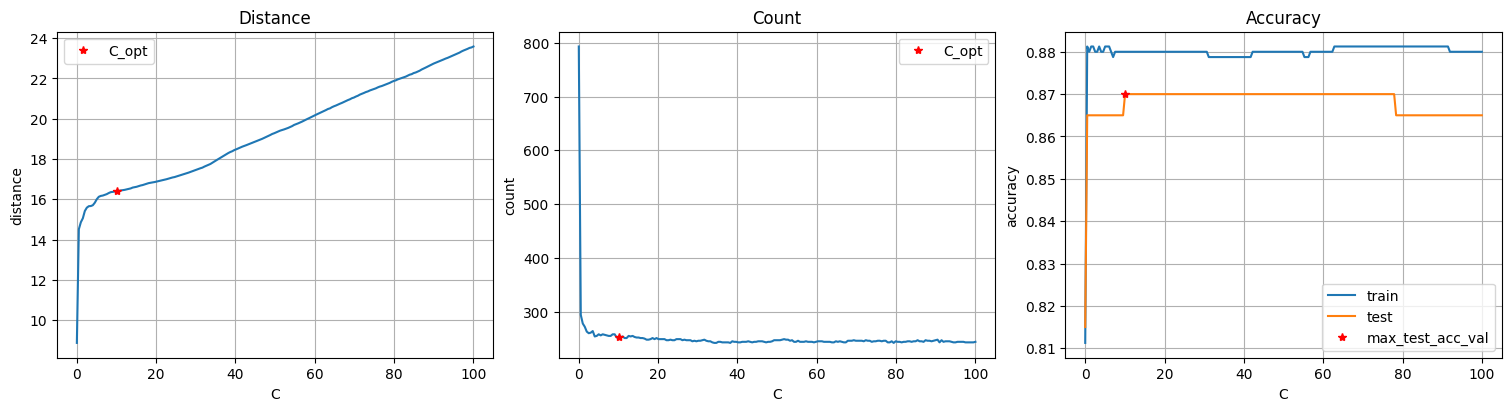

In [10]:
%%time

param_C = np.linspace(0.01, 100,  200)
metrics = {'distance': [], 'count': [], 'train': [], 'test': []}
for C in param_C:
    model = sk.svm.SVC(C=C, gamma=1.0, decision_function_shape='ovo')
    model.fit(x_train,y_train)
    metrics['distance'].append(np.linalg.norm(model.decision_function(x_test)))
    metrics['count'].append(model.n_support_.sum())
    metrics['train'].append(model.score(x_train, y_train))
    metrics['test'].append(model.score(x_test, y_test))

_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*5, 4))
ax0.plot(param_C, metrics['distance'])
ax0.set(xlabel = 'C', ylabel = 'distance', title='Distance')
ax1.plot(param_C, metrics['count'])
ax1.set(xlabel = 'C', ylabel = 'count', title='Count')
ax2.plot(param_C, metrics['train'], label = 'train')
ax2.plot(param_C, metrics['test'], label = 'test')
ax2.set(xlabel = 'C', ylabel = 'accuracy', title='Accuracy')

opt_ind = np.argmax(metrics['test'])
C_opt = param_C[opt_ind]

ax0.plot(C_opt,metrics['distance'][opt_ind], '*r', label = 'C_opt')
ax0.legend()
ax1.plot(C_opt,metrics['count'][opt_ind], '*r', label = 'C_opt')
ax1.legend()
ax2.plot(C_opt,metrics['test'][opt_ind], '*r', label = 'max_test_acc_val')
ax2.legend()

print(f"Optimal C = {C_opt}, test accuracy = {metrics['test'][opt_ind]}, train accuracy = {metrics['train'][opt_ind]}")

**Вопросы:**

1. Какое значение принимает оптимальный параметр регуляризации `C`?
1. Как ведёт себя ширина зазора при увеличении параметра `C`?
1. Что происходит с количеством опорных векторов при увеличении параметра `C`?

**Ответы:**

1. 10.059246231155777
2. При увеличении параметра C ширина зазора увеличивается
3. С ростом `C` уменьшается количество опорных векторов 



### Задание №3.2

* Постройте графики зависимостей числа опорных векторов и ширины зазора от параметра $\sigma$, используя найденное оптимальное $C$.
* Постройте графики зависимостей точности (accuracy) от параметра $\sigma$ для обучающей и тестовой выборок, на основе чего выберите оптимальный параметр $\sigma$.
* Для параметра $\sigma$ используйте логарифмический масштаб.

Optimal sigma = 1.005974874371859, test accuracy = 0.87, train accuracy = 0.88
CPU times: total: 19.9 s
Wall time: 20.1 s


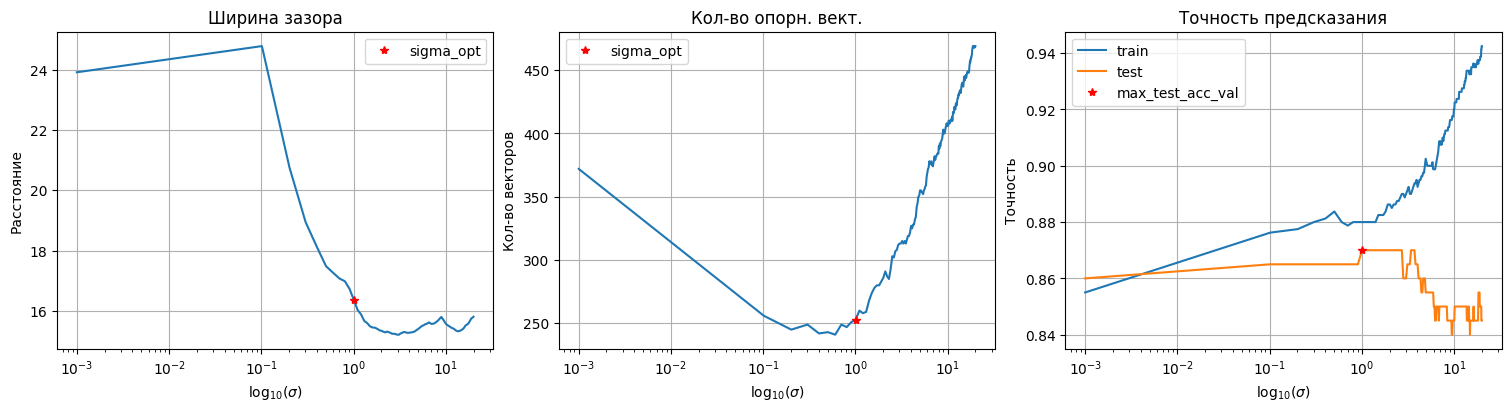

In [12]:
%%time

param_sigma = np.linspace(0.001, 20.0, 200)
metrics = {'distance': [], 'count': [], 'train': [], 'test': []}
for sigma in param_sigma:
    model = sk.svm.SVC(C=C_opt, gamma = sigma, decision_function_shape='ovo')
    model.fit(x_train,y_train)
    metrics['distance'].append(np.linalg.norm(model.decision_function(x_test)))
    metrics['count'].append(model.n_support_.sum())
    metrics['train'].append(model.score(x_train, y_train))
    metrics['test'].append(model.score(x_test, y_test))

_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*5, 4))
ax0.semilogx(param_sigma, metrics['distance'])
ax0.set(xlabel='$\log_{10}(\sigma)$', ylabel='Расстояние', title='Ширина зазора')
ax1.semilogx(param_sigma, metrics['count'])
ax1.set(xlabel='$\log_{10}(\sigma)$', ylabel='Кол-во векторов', title='Кол-во опорн. вект.')
ax2.semilogx(param_sigma, metrics['train'], label = 'train')
ax2.semilogx(param_sigma, metrics['test'], label = 'test')
ax2.set(xlabel='$\log_{10}(\sigma)$', ylabel='Точность', title='Точность предсказания')

opt_ind = np.argmax(metrics['test'])
sigma_opt = param_sigma[opt_ind]

ax0.plot(sigma_opt,metrics['distance'][opt_ind], '*r', label = 'sigma_opt')
ax0.legend()
ax1.plot(sigma_opt,metrics['count'][opt_ind], '*r', label = 'sigma_opt')
ax1.legend()
ax2.plot(sigma_opt,metrics['test'][opt_ind], '*r', label = 'max_test_acc_val')
ax2.legend()

print(f"Optimal sigma = {sigma_opt}, test accuracy = {metrics['test'][opt_ind]}, train accuracy = {metrics['train'][opt_ind]}")

**Вопросы:**

1. Как ведёт себя значение ширины зазора при изменении значения параметра $\sigma$?
1. Как изменяется число опорных векторов при уменьшении/увеличении значения парметра $\sigma$?
1. Удалось ли улучшить результаты классификации?

**Ответы:**

1. С ростом $\sigma$ ширина зазора увеличивается
2. С ростом $\sigma$ число опорных точек уменьшается, но потом достигается порог, после которого с ростом $\sigma$ число опорных точек увеличивается
3. Не удалось

### Задание №3.3

Визуализируйте разделение пространства признаков для наилучшей модели.

poly5 train score: 0.88 test score: 0.87 n_support: [127 126]


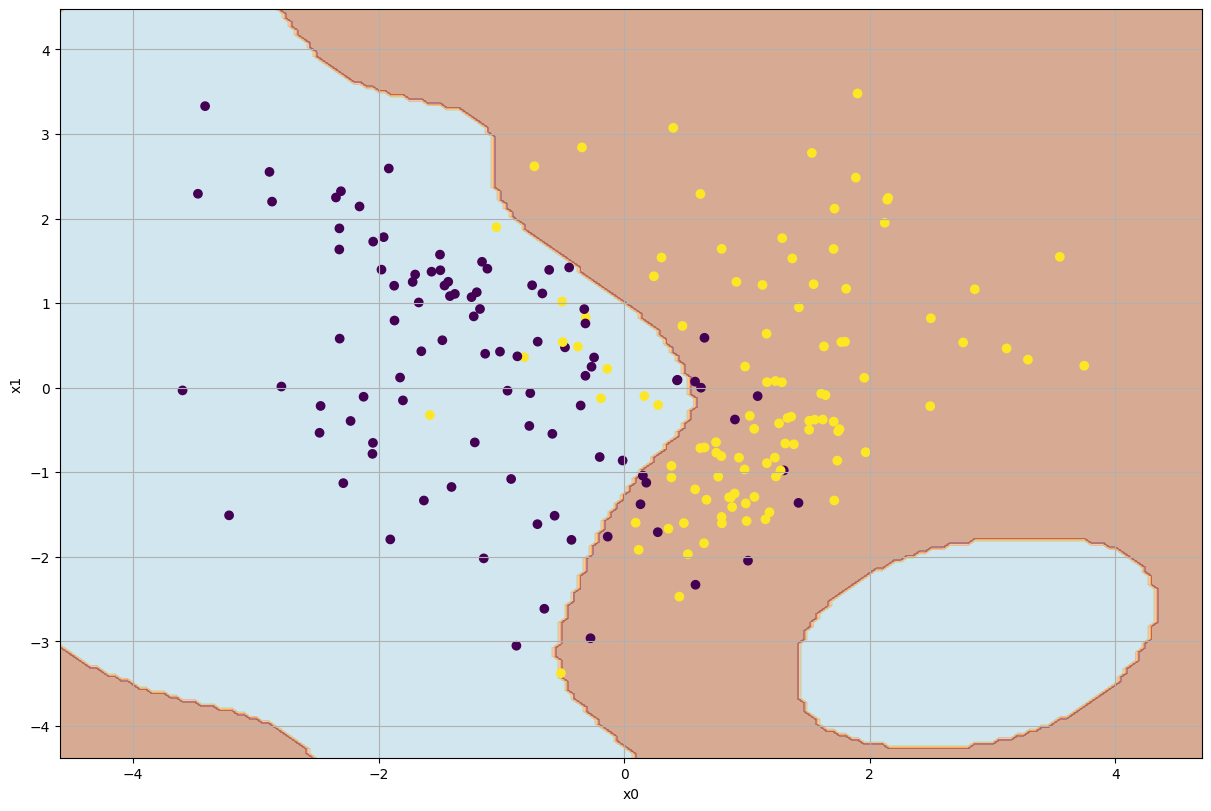

In [14]:
model = sk.svm.SVC(kernel='rbf', C=C_opt, gamma=sigma_opt)
model.fit(x_train,y_train)
Z = model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.xlabel('x0')
plt.ylabel('x1')

print(name, 'train score:', model.score(x_train, y_train), 'test score:', model.score(x_test, y_test), 'n_support:', model.n_support_)

**Вопросы:**

* Удалось ли увеличить качество модели (со скольких до скольких) по сравнению с предыдущим заданием?
Как при этом изменилась форма разделяющей поверхности? 
* Сделайте вывод о влиянии параметров $C$ и $\sigma$ на сложность модели и ширину зазора.

**Ответы:**

1. Не удалось. Внутри поверхности появилось пустая замкнутая область для фиолетовых точек
2. С ростом $C$ ширина зазора растет, а количество опорных точек уменьшается. С ростом $\sigma$  число опорных точек уменьшается, но потом достигается порог  после которого с ростом чилосло опорных точек увеличивается

## Задание №4

Подготовьте датасет с нелинейными данными. Координата `x` генериурется как отрезок $[-1; 1]$ в количестве 100 отсчётов, `y` генерируется согласно варианту.
Разделите датасет на обучающую и тестовую выборки.
Размер тестовой выборки следует выбрать равным 20% от размера всей выборки.

Функция для генерации `y` компоненты датасета (выбирается согласно формуле `1 + (<порядковый номер> % 2)`:

1. `np.arctan(A * x - 0.23) + 0.1`
1. `np.sin(A * x + 0.1) - 0.43`

Число `A` вычисляется по формуле `4 + (<порядковый номер> % 5)`.

(80, 1) (80,)


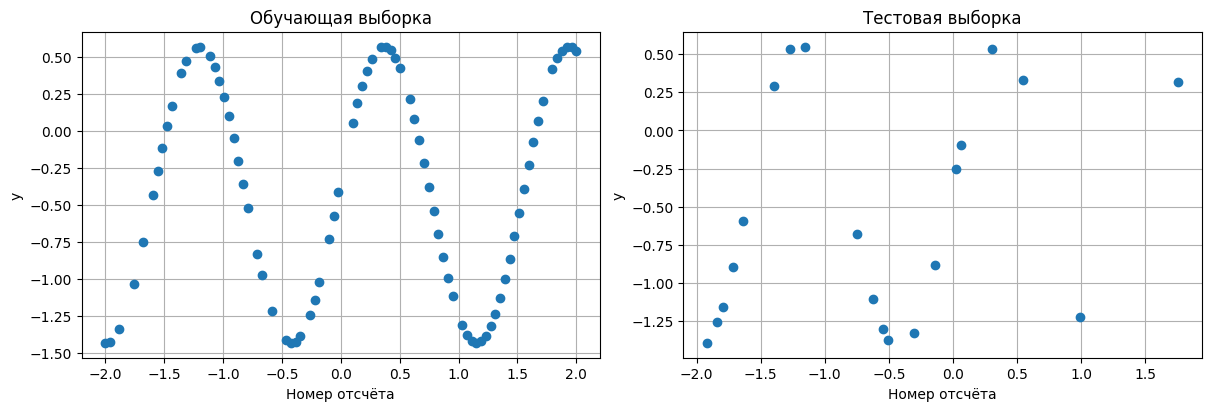

In [18]:
# порядковый номер = 5
x = np.linspace(-2.0, 2.0, 100)
A = 4 + (5 % 5)
y = np.sin(A * x + 0.1) - 0.43
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(np.expand_dims(x, -1), y, test_size=0.2, random_state=78)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0.plot(x_train, y_train, 'o')
ax0.set(xlabel='Номер отсчёта', ylabel='y', title='Обучающая выборка')
ax1.plot(x_test, y_test, 'o')
ax1.set(xlabel='Номер отсчёта', ylabel='y', title='Тестовая выборка')
print(x_train.shape, y_train.shape)

## Задание №5

Рассмотрим задачу регрессии с использованием машин опорных векторов (`sk.svm.SVR`).
Постройте графики, на которых изображены истинные и предсказанные значения для следующих ядер:

* линейное,
* полиномиальные (порядков 2-10),
* радиальное RBF.

Для каждого из ядер найдите MSE-ошибки на обучающей и тестовой выборках.
На основе полученных значений MSE выберите наилучшую модель.
Для полиномиальных ядер в отчет включите только ту модель, которая дает наилучший результат.

linear train MSE: 0.5086823582523008 test MSE: 0.5728008450319899 n_support: 74
rbf train MSE: 0.15890925487169127 test MSE: 0.22081416570425327 n_support: 72
poly2 train MSE: 0.5152321517446963 test MSE: 0.627627544466273 n_support: 73
poly3 train MSE: 0.503770476524411 test MSE: 0.4663306760749558 n_support: 75
poly4 train MSE: 0.5368178493073215 test MSE: 0.7322281199206347 n_support: 74
poly5 train MSE: 0.4481724158394698 test MSE: 0.4325096162746986 n_support: 71
poly6 train MSE: 0.5437042998862116 test MSE: 0.7573308449156192 n_support: 72
poly7 train MSE: 0.4210704418933176 test MSE: 0.41923916976808295 n_support: 72
poly8 train MSE: 0.5405574871040804 test MSE: 0.7368206465197458 n_support: 72
poly9 train MSE: 0.4105586452405726 test MSE: 0.4196957141297289 n_support: 73
poly10 train MSE: 0.5384299535843964 test MSE: 0.7088804457369118 n_support: 73


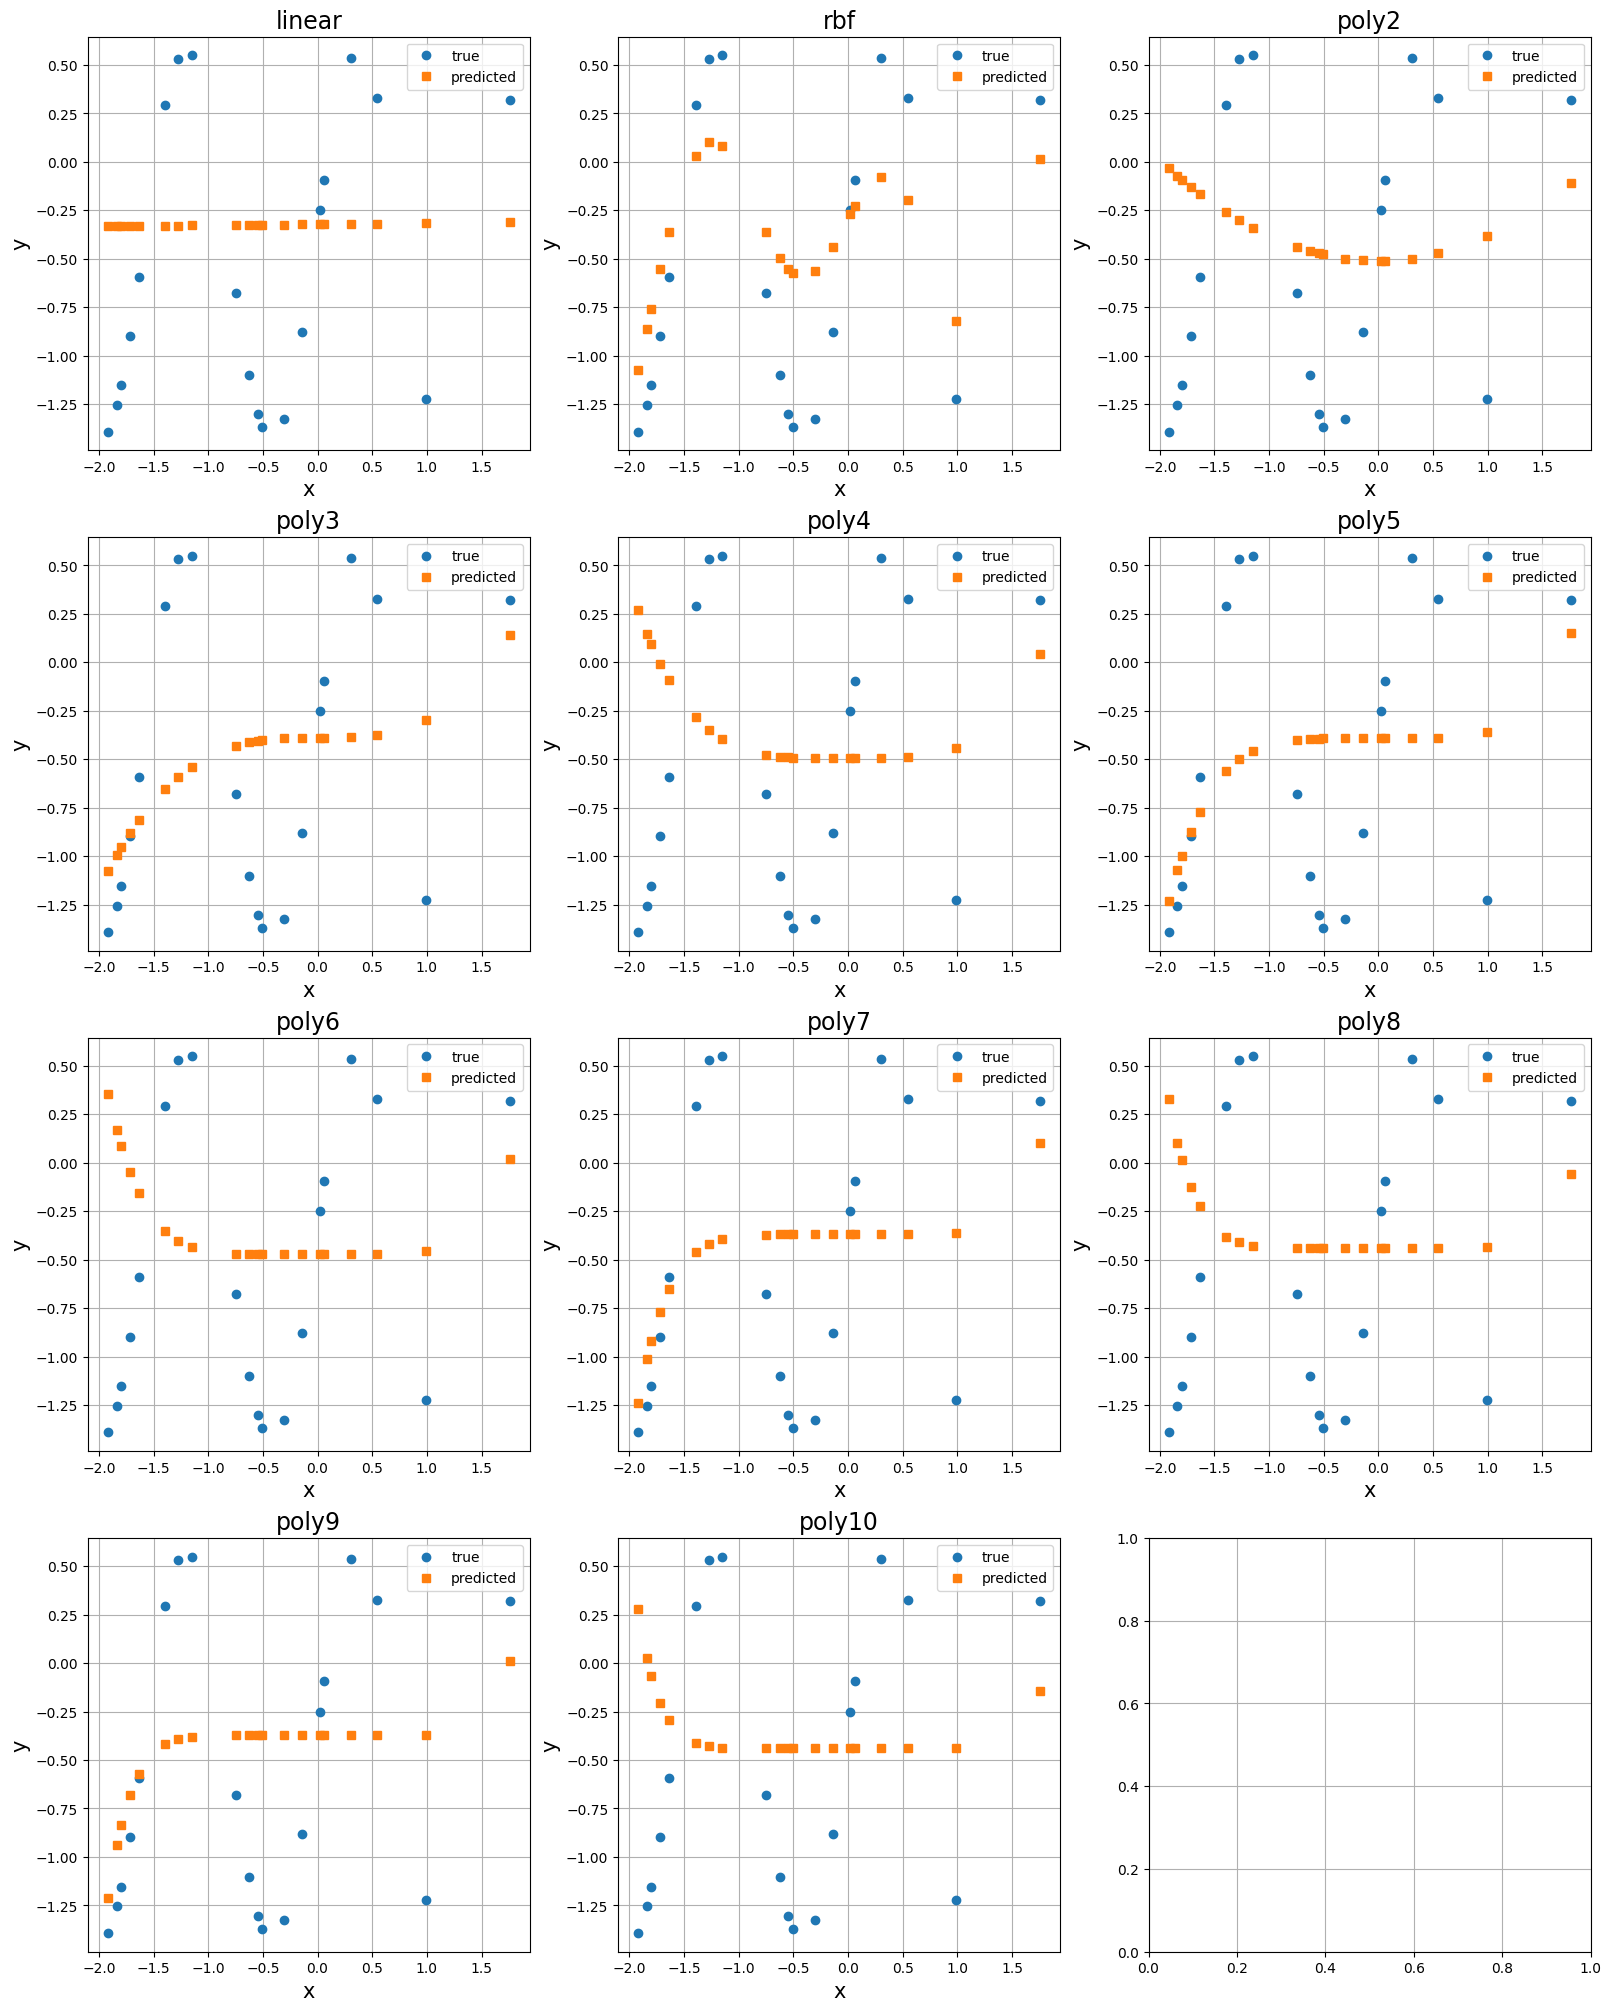

In [20]:
models = {'linear': sk.svm.SVR(kernel='linear'), 'rbf': sk.svm.SVR(kernel='rbf')}
for i in range(2, 11):
    models[f'poly{i}'] = sk.svm.SVR(kernel='poly', degree = i)

fig, axes = plt.subplots(len(models) // 3 + 1, 3, figsize=(16, 20))
i = 0
for (name, model) in models.items():
    ax = axes[i // axes.shape[1],i % axes.shape[1]]
    model.fit(x_train,y_train)
    test_pred = model.predict(x_test)
    ax.plot(x_test, y_test, 'o', label='true')
    ax.plot(x_test, test_pred, 's', label='predicted')
    ax.set(title=name)
    ax.title.set_size(17)
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.legend()
    i += 1
    
    err_train = ((model.predict(x_train) - y_train) ** 2).mean()
    err_test = ((model.predict(x_test) - y_test) ** 2).mean()
    print(name, 'train MSE:', err_train, 'test MSE:', err_test, 'n_support:', model.n_support_.sum())

**Вопросы:**

1. Насколько модели показывают правдоподобные результаты?
1. Какая модель даёт меньшую ошибку MSE?
1. Какая модель использует меньшее количество опорных векторов?

**Ответы:**

1. Наиболее правдоподобный результат показал RBF
2. RBF
3. RBF.

## Задание №6

Попробуйте улучшить результат, полученный оптимальной моделью из предыдущего задания.
Для этого следует подобрать параметры регуляризации $C$ и $\varepsilon$ одновременно с помощью функции
[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
При построении решётки параметров для `C` используйте `np.linspace`, для `epsilon` - `np.logspace`.
Можно подбирать диапазоны поэтапно: от широкого, но с большим шагом, до более маленьго диапазона с меньшим шагом.
Найти самый оптимальный минимум не требуется.
Вполне можно остановиться на MSE $\approx 10^{-5}$.

### Задание №6.1

Постройте график, на котором изображены истинные и предсказанные значения для наилучшей модели.

{'C': 170.0, 'epsilon': 6.158482110660255e-06}
MSE = 3.1859861232183393e-07 vectors = 80
CPU times: total: 4.91 s
Wall time: 1min 32s


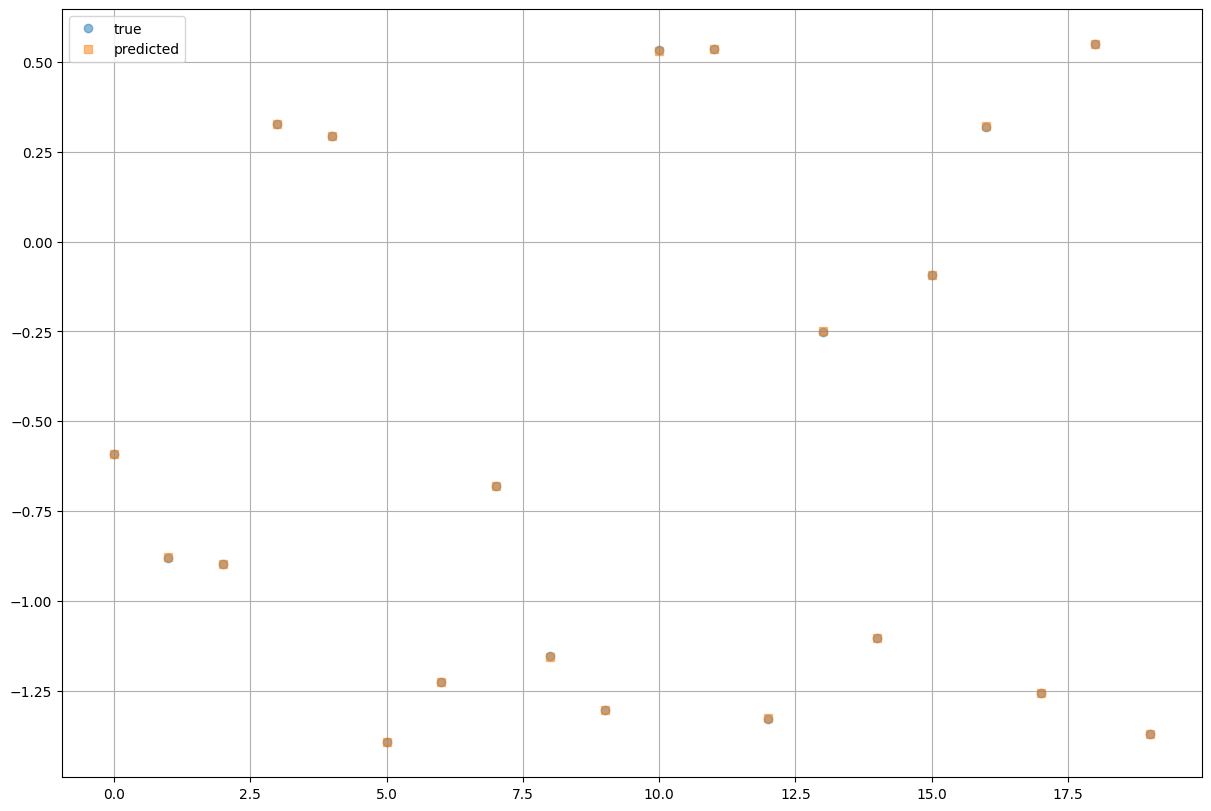

In [21]:
%%time

param_grid = {'C': np.linspace(100, 170.0, 20), 'epsilon': np.logspace(-9.0, -5.0, num=20)}
model = sk.model_selection.GridSearchCV(sk.svm.SVR(kernel='rbf'), param_grid, n_jobs=-1)
model.fit(x_train, y_train)
print(model.best_params_)

y_pred = model.best_estimator_.predict(x_test)
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.plot(y_test, 'o', label='true', alpha=0.5)
plt.plot(y_pred, 's', label='predicted', alpha=0.5)
plt.legend()
print("MSE =", ((y_test - y_pred) ** 2).mean(), "vectors =", model.best_estimator_.n_support_.sum())

**Вопросы:**

1. Удалось ли увеличить качество модели по сравнению с предыдущим заданием? Насколько?
1. Сравние количество опорных векторов в полученной модели и в прошлой.
1. Как изменился график предсказанной зависимости?

**Ответы:**

1. Качество модели заметно улучшилось, MSE изменилось в несколько порядков
2. В новой модели 80 опорных векторов против 72 из старой
3. Графи стал больше похож на искомую зависимость

### Задание №6.2

Постройте графики зависимостей числа опорных векторов от $C$ и от $\varepsilon$.
В качестве свободных параметров используйте те, которые нашли на предыдущем шаге.

CPU times: total: 7.67 s
Wall time: 7.71 s


[Text(0.5, 0, 'epsilon'),
 Text(0, 0.5, 'Количество'),
 Text(0.5, 1.0, 'Количество векторов от epsilon')]

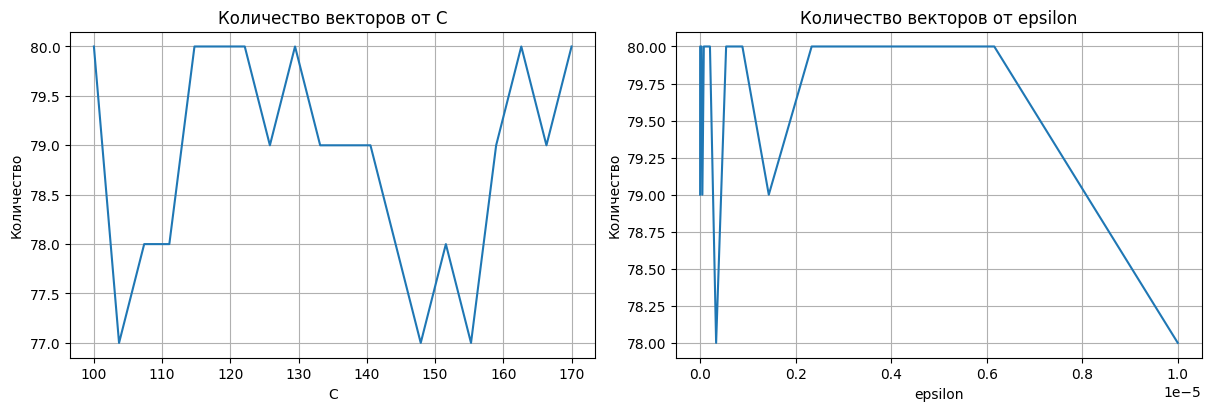

In [22]:
%%time

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))

n_support = []
for C in param_grid['C']:
    m = sk.svm.SVR(C = C, epsilon=model.best_params_['epsilon'])
    m.fit(x_train,y_train)
    n_support.append(m.n_support_.sum())

ax0.plot(param_grid['C'], n_support)
ax0.set(xlabel='C', ylabel='Количество', title='Количество векторов от C')

n_support = []
for eps in param_grid['epsilon']:
    m = sk.svm.SVR(C = model.best_params_['C'], epsilon=eps)
    m.fit(x_train,y_train)
    n_support.append(m.n_support_.sum())

ax1.plot(param_grid['epsilon'], n_support)
ax1.set(xlabel='epsilon', ylabel='Количество', title='Количество векторов от epsilon')

**Вопросы:**

1. Как влияют параметры регуляризации $C$ и $\varepsilon$ на сложность модели?

**Ответы:**

1. С ростом $C$
 количество опорных векторов возрастае. При значительном увеличении  $\varepsilon$ сложность модели (число опорных векторов) уменьшается,